Starting Transfer Analysis: Accuracy & Consistency...
Analyzing folder: ../outputs
----------------------------------------------------------------------------------------------------

**Filtering for:**
  Source models: ['DeepSeek', 'Llama-3.2-3B', 'Qwen-2.5-1.5B', 'DeepSeek-GRPO', 'Llama-GRPO', 'Qwen-GRPO']
  Target models: ['OSS', 'DAPO', 'QwQ', 'OpenT', 'NRR']
  Conditions: with_answer, without_answer

Qwen-2.5-1.5B -> DAPO [with_answer]: Loaded 100 data points
Qwen-2.5-1.5B -> QwQ [with_answer]: Loaded 100 data points
Qwen-2.5-1.5B -> NRR [with_answer]: Loaded 100 data points
Qwen-2.5-1.5B -> OpenT [with_answer]: Loaded 100 data points
Qwen-2.5-1.5B -> OSS [with_answer]: Loaded 100 data points
DeepSeek-GRPO -> DAPO [with_answer]: Loaded 100 data points
DeepSeek-GRPO -> QwQ [with_answer]: Loaded 100 data points
DeepSeek-GRPO -> NRR [with_answer]: Loaded 100 data points
DeepSeek-GRPO -> OpenT [with_answer]: Loaded 100 data points
DeepSeek-GRPO -> OSS [with_answer]: Loaded 100 data p

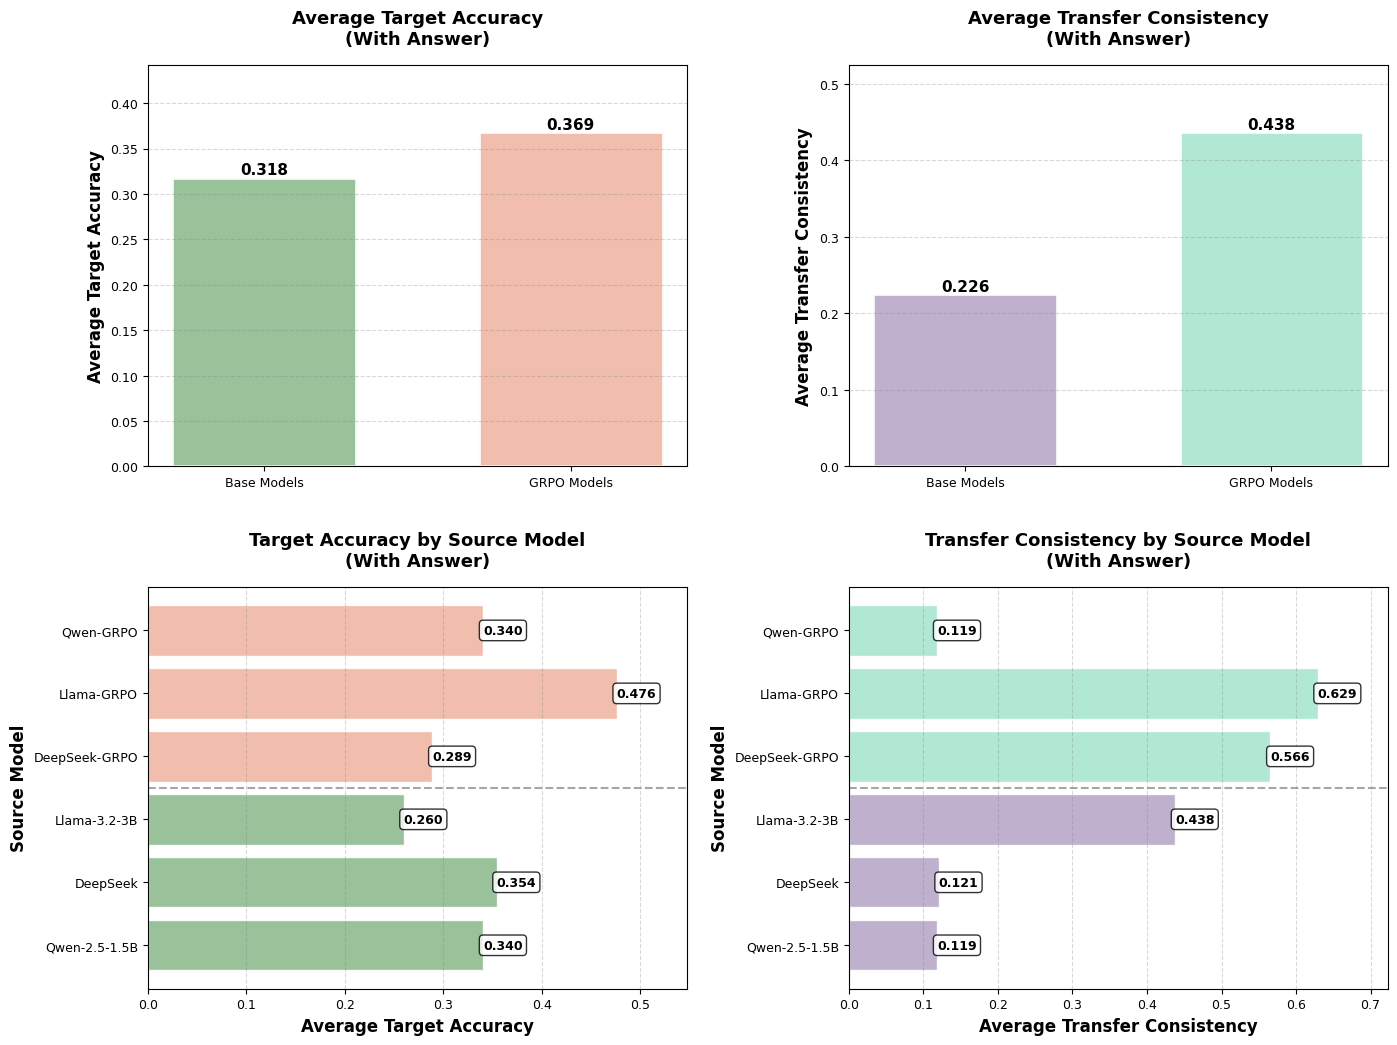

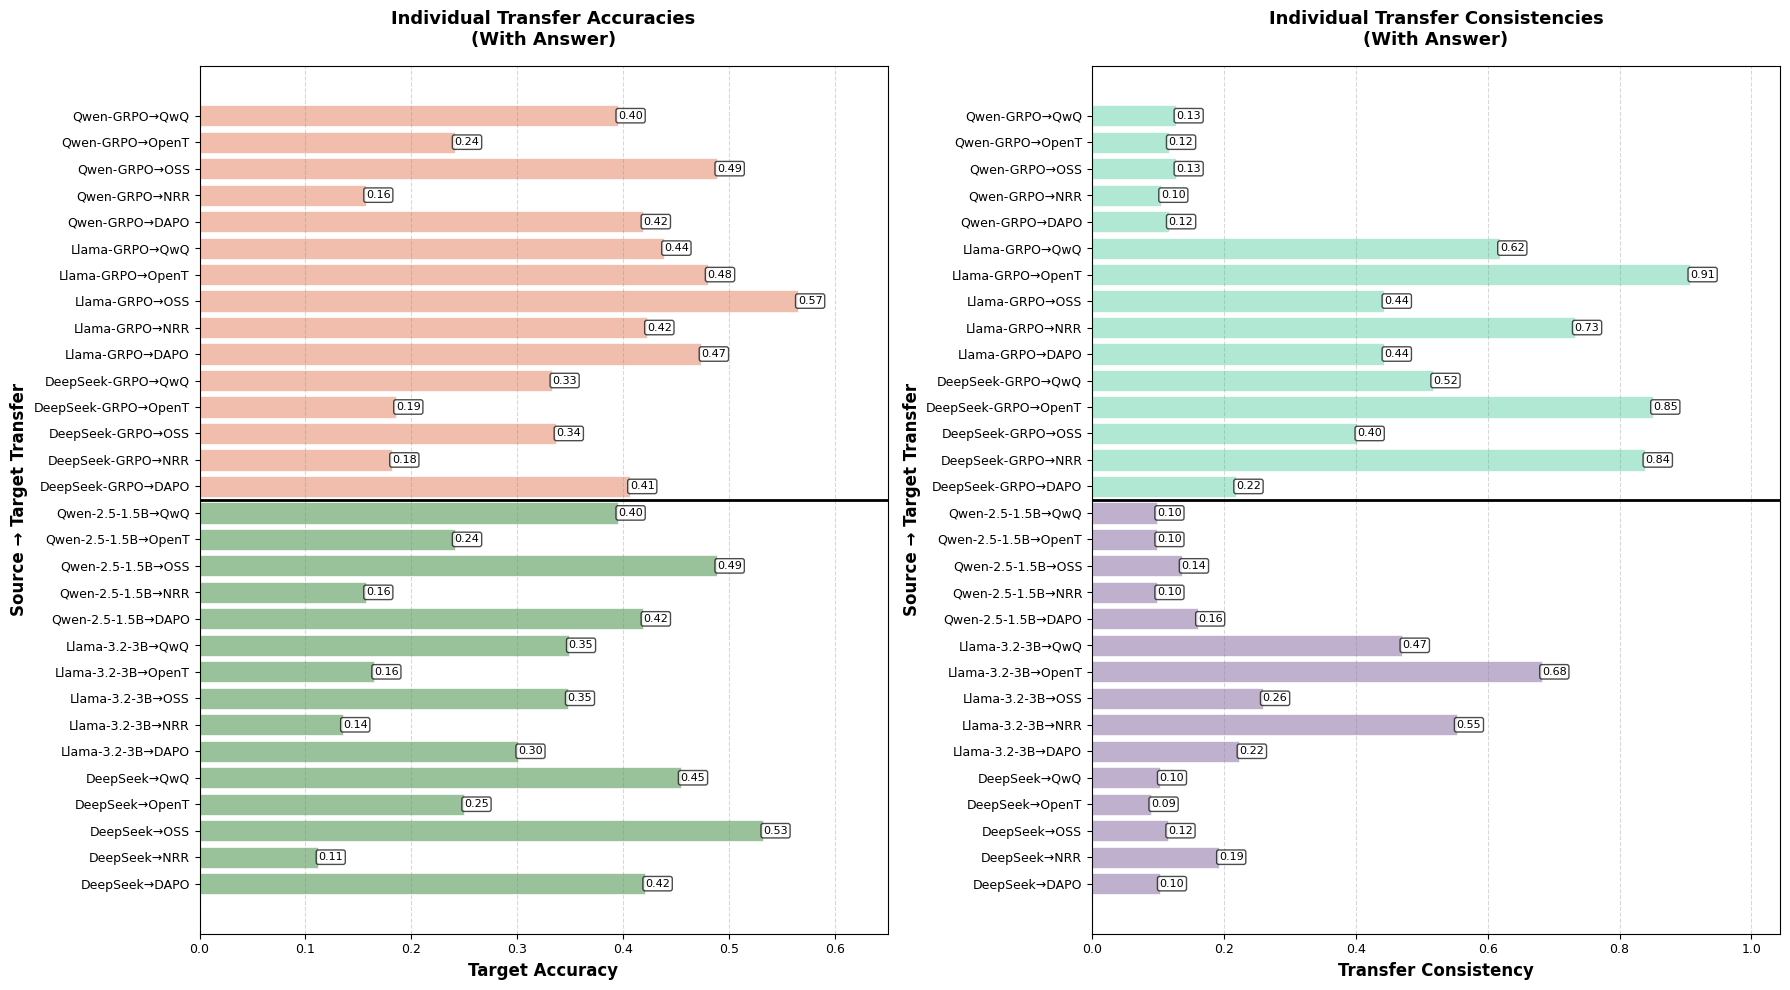


SUMMARY: WITH ANSWER

Group                      Avg Target Accuracy       Avg Transfer Consistency
----------------------------------------------------------------------------------------------------
Base Models                              0.318                          0.226
GRPO Models                              0.369                          0.438

DETAILED BREAKDOWN BY SOURCE MODEL

BASE MODELS
----------------------------------------------------------------------------------------------------
  Qwen-2.5-1.5B             Avg Accuracy: 0.340  |  Avg Consistency: 0.119
  DeepSeek                  Avg Accuracy: 0.354  |  Avg Consistency: 0.121
  Llama-3.2-3B              Avg Accuracy: 0.260  |  Avg Consistency: 0.438

GRPO MODELS
----------------------------------------------------------------------------------------------------
  DeepSeek-GRPO             Avg Accuracy: 0.289  |  Avg Consistency: 0.566
  Llama-GRPO                Avg Accuracy: 0.476  |  Avg Consistency: 0.629
  Q

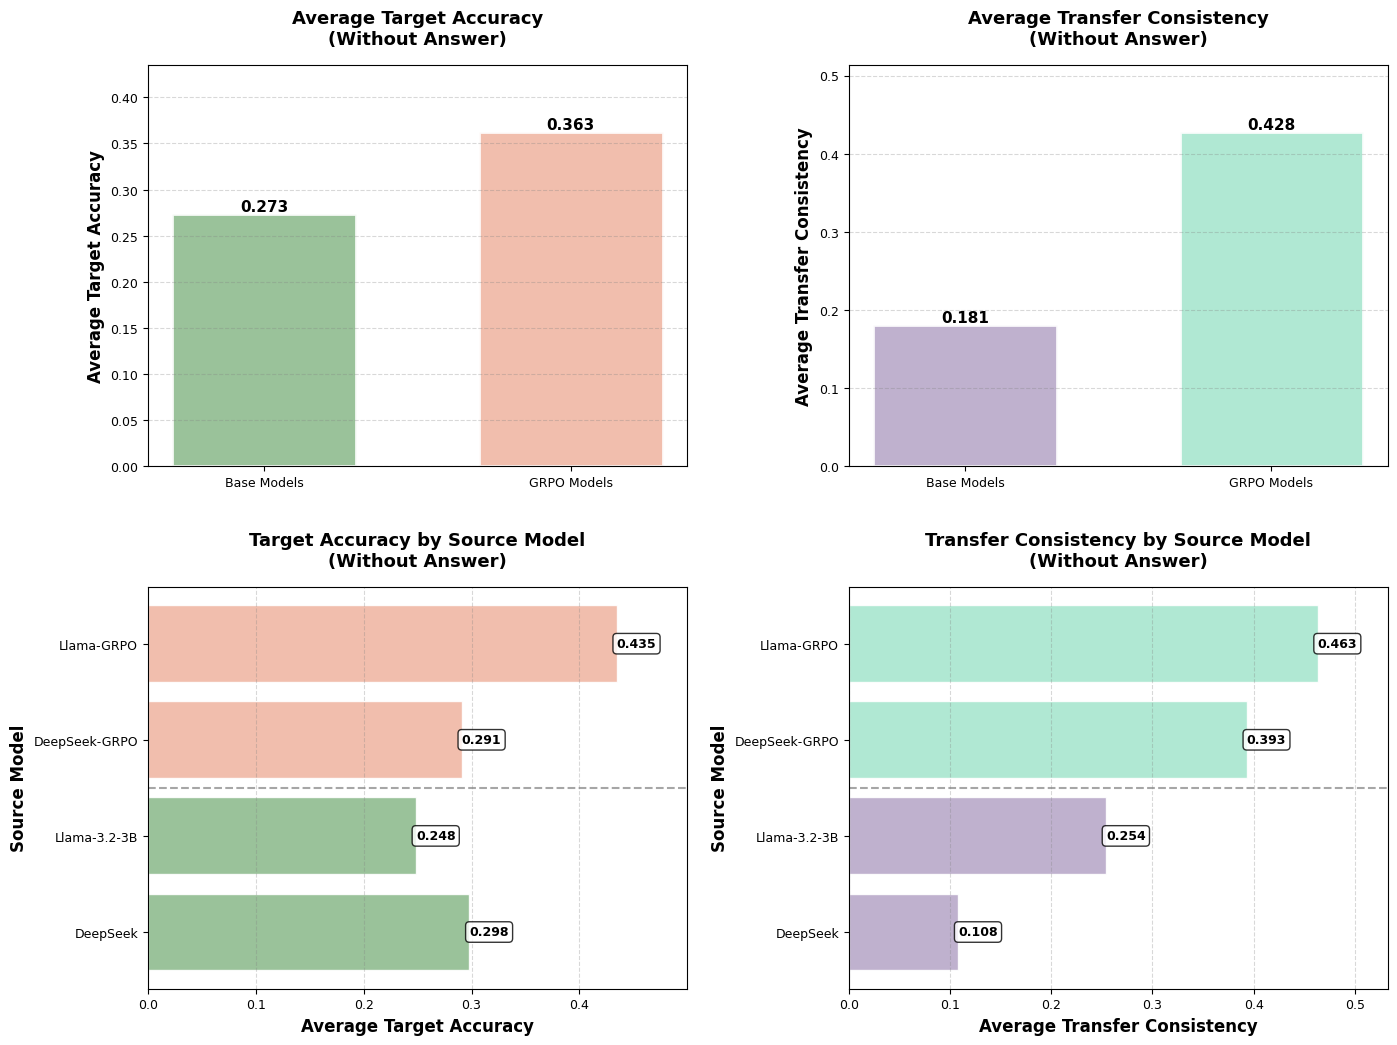

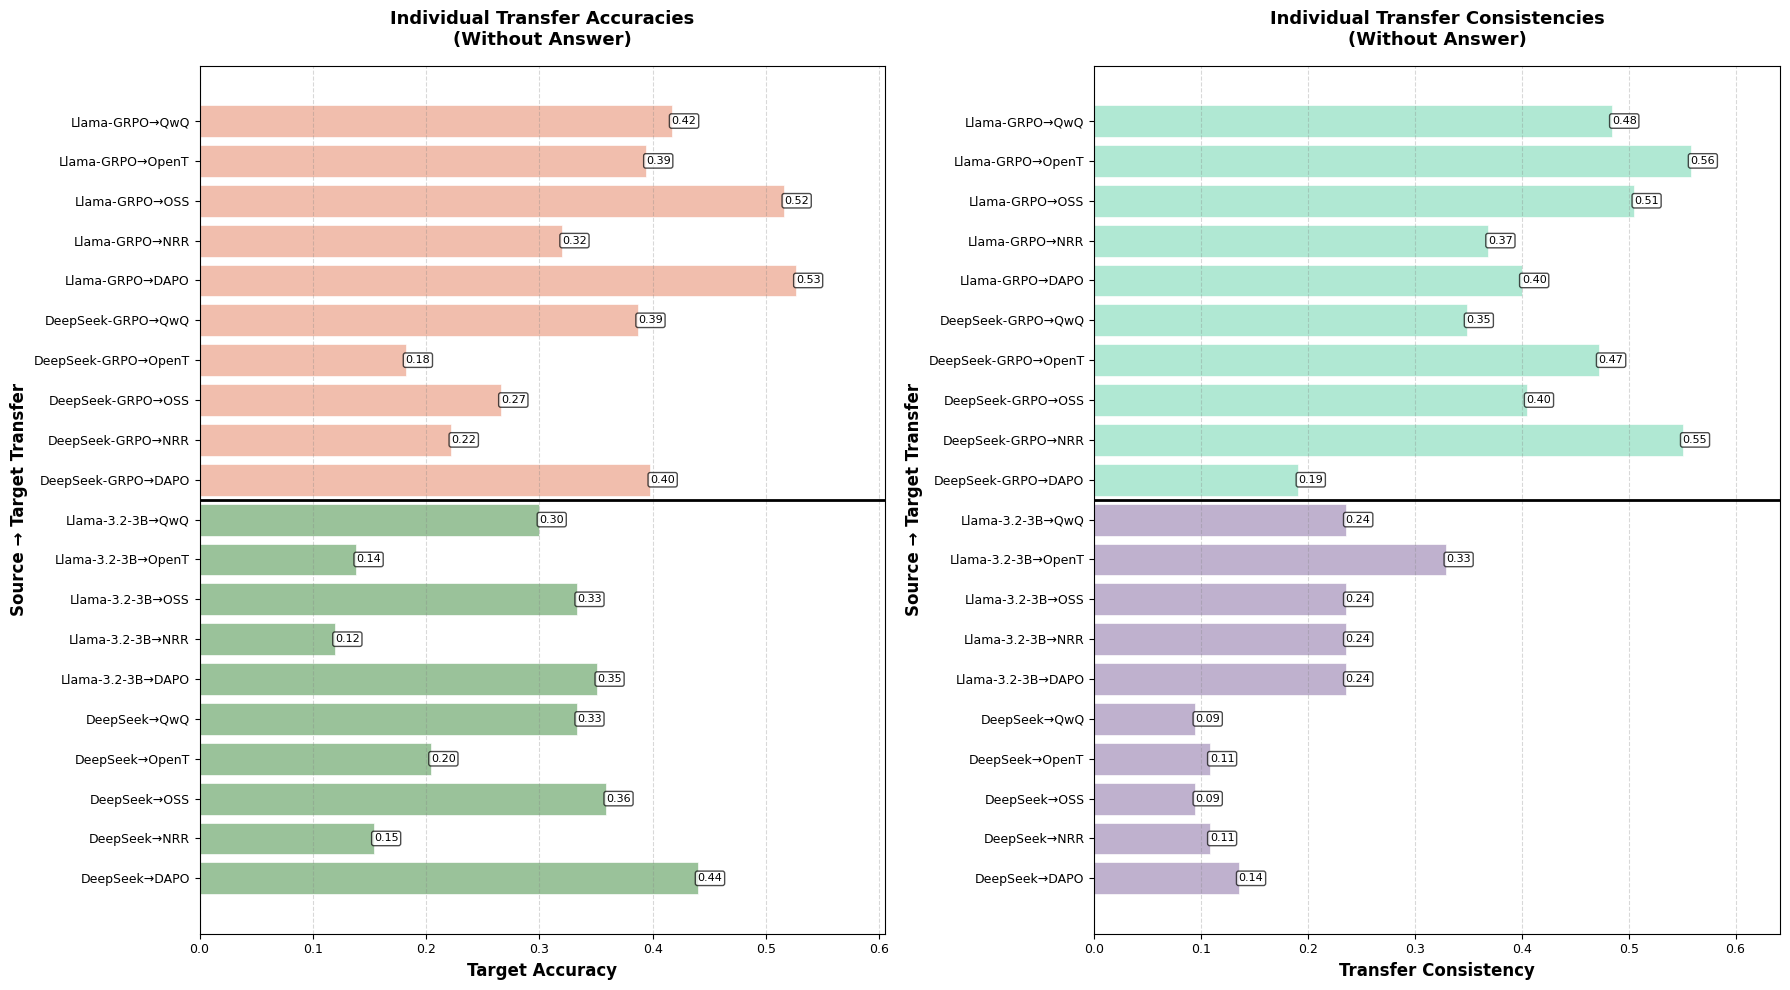


SUMMARY: WITHOUT ANSWER

Group                      Avg Target Accuracy       Avg Transfer Consistency
----------------------------------------------------------------------------------------------------
Base Models                              0.273                          0.181
GRPO Models                              0.363                          0.428

DETAILED BREAKDOWN BY SOURCE MODEL

BASE MODELS
----------------------------------------------------------------------------------------------------
  DeepSeek                  Avg Accuracy: 0.298  |  Avg Consistency: 0.108
  Llama-3.2-3B              Avg Accuracy: 0.248  |  Avg Consistency: 0.254

GRPO MODELS
----------------------------------------------------------------------------------------------------
  DeepSeek-GRPO             Avg Accuracy: 0.291  |  Avg Consistency: 0.393
  Llama-GRPO                Avg Accuracy: 0.435  |  Avg Consistency: 0.463

✓ All plots saved to: transfer_analysis_complete.pdf

Analysis completed s

In [1]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import warnings

warnings.filterwarnings('ignore')

plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 100,
})

BAR_COLORS = ['#8FBC8F', '#F0B7A4', '#B8A9C9', '#A8E6CF']

SOURCE_MODELS = [
    'deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B',
    'meta-llama_Llama-3.2-3B-Instruct',
    'Qwen_Qwen2.5-1.5B-Instruct',
    '_disk_u_koyena_medcalc-deepseek-r1-distill-qwen-1.5b-inst-grpo',
    '_disk_u_koyena_medcalc-llama-3-3b-inst-grpo',
    '_disk_u_koyena_medcalc-qwen-2.5-1.5b-inst-grpo'
]

TARGET_MODELS = [
    'openai_gpt-oss-20b',
    'BytedTsinghua-SIA_DAPO-Qwen-32B',
    'Qwen_QwQ-32B',
    'open-thoughts_OpenThinker-7B',
    'nvidia_Nemotron-Research-Reasoning-Qwen-1.5B'
]


def create_short_model_names():
    return {
        'openai_gpt-oss-20b': 'OSS',
        'BytedTsinghua-SIA_DAPO-Qwen-32B': 'DAPO',
        'Qwen_QwQ-32B': 'QwQ',
        'open-thoughts_OpenThinker-7B': 'OpenT',
        'nvidia_Nemotron-Research-Reasoning-Qwen-1.5B': 'NRR',
        'deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B': 'DeepSeek',
        'meta-llama_Llama-3.2-3B-Instruct': 'Llama-3.2-3B',
        'Qwen_Qwen2.5-1.5B-Instruct': 'Qwen-2.5-1.5B',
        '_disk_u_koyena_medcalc-deepseek-r1-distill-qwen-1.5b-inst-grpo': 'DeepSeek-GRPO',
        '_disk_u_koyena_medcalc-llama-3-3b-inst-grpo': 'Llama-GRPO',
        '_disk_u_koyena_medcalc-qwen-2.5-1.5b-inst-grpo': 'Qwen-GRPO',
    }


def parse_jsonl_file(filepath):
    data_points = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue
                try:
                    data_points.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Error parsing line {line_num} in {filepath}: {e}")
    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
    return data_points


def extract_model_names_and_condition(filename):
    pattern = r'(.+)_thoughts_to_(.+)_zero_shot'
    match = re.match(pattern, filename)
    if match:
        condition = "without" if "without_answer" in filename else "with"
        return match.group(1), match.group(2), condition
    return None, None, None


def check_consistency(dp1, dp2):
    ans1 = dp1.get("Target Answer", "")
    res1 = dp1.get("Target Result", "")
    ans2 = dp2.get("Target Answer", "")
    res2 = dp2.get("Target Result", "")
    
    invalid = ["not defined", "N/A", "does not match", "are not permitted"]
    if any(p in ans1 or p in ans2 for p in invalid):
        return None
    
    return 1 if ans1 == ans2 or (res1 == "Correct" and res2 == "Correct") else 0


def load_data(folder_path, filter_source_models=None, filter_target_models=None):
    if not os.path.exists(folder_path):
        print(f"Folder path does not exist: {folder_path}")
        return None
    
    data_by_source = {'with': {}, 'without': {}}
    model_names = set()
    
    jsonl_files = [f for f in os.listdir(folder_path)
                   if f.endswith('.jsonl') and '_thoughts_to_' in f]
    
    if not jsonl_files:
        print("No JSONL files found matching the expected pattern.")
        return None
    
    name_mapping = create_short_model_names()
    print(f"\n**Filtering for:**")
    print(f"  Source models: {[name_mapping.get(m, m) for m in filter_source_models]}")
    print(f"  Target models: {[name_mapping.get(m, m) for m in filter_target_models]}")
    print(f"  Conditions: with_answer, without_answer\n")
    
    for filename in jsonl_files:
        source_model, target_model, condition = extract_model_names_and_condition(filename)
        
        if not (source_model and target_model and condition):
            continue
        
        if filter_source_models and source_model not in filter_source_models:
            continue
        if filter_target_models and target_model not in filter_target_models:
            continue
        
        model_names.add(source_model)
        model_names.add(target_model)
        
        filepath = os.path.join(folder_path, filename)
        data_points = parse_jsonl_file(filepath)
        
        if data_points:
            data_by_source[condition][(source_model, target_model)] = data_points
            short_source = name_mapping.get(source_model, source_model[:10])
            short_target = name_mapping.get(target_model, target_model[:10])
            print(f"{short_source} -> {short_target} [{condition}_answer]: "
                  f"Loaded {len(data_points)} data points")
    
    return data_by_source, sorted(list(model_names))


def calculate_accuracy(data_points):
    if not data_points:
        return None, 0, 0
    
    correct = 0
    total = 0
    
    for dp in data_points:
        result = dp.get("Target Result", "")
        if result:
            total += 1
            if result == "Correct":
                correct += 1
    
    accuracy = correct / total if total > 0 else None
    return accuracy, correct, total


def calculate_transfer_consistency(source_data, target_data):
    consistent = 0
    total = 0
    
    for idx in range(min(len(source_data), len(target_data))):
        dp_source = {
            "Target Answer": source_data[idx].get("LLM Answer", ""),
            "Target Result": source_data[idx].get("Result", "")
        }
        dp_target = {
            "Target Answer": target_data[idx].get("Target Answer", ""),
            "Target Result": target_data[idx].get("Target Result", "")
        }
        
        result = check_consistency(dp_source, dp_target)
        if result is not None:
            total += 1
            consistent += result
    
    consistency = consistent / total if total > 0 else None
    return consistency, consistent, total


def analyze_transfers(data_by_source, condition_name):
    name_mapping = create_short_model_names()
    results = {}
    
    sources = sorted(set(src for (src, _) in data_by_source.keys()))
    
    print(f"\n{'='*100}")
    print(f"Analyzing transfers: {condition_name.upper()}")
    print(f"{'='*100}")
    
    for source in sources:
        short_source = name_mapping.get(source, source[:10])
        results[source] = {'targets': {}}
        
        targets = [t for (s, t) in data_by_source.keys() if s == source]
        
        if not targets:
            continue
            
        source_data = data_by_source[(source, targets[0])]
        
        print(f"\n{short_source}:")
        
        for target in targets:
            short_target = name_mapping.get(target, target[:10])
            target_data = data_by_source[(source, target)]
            
            target_acc, tgt_corr, tgt_tot = calculate_accuracy(target_data)
            consistency, cons_count, cons_tot = calculate_transfer_consistency(source_data, target_data)
            
            results[source]['targets'][target] = {
                'target_accuracy': {
                    'accuracy': target_acc,
                    'correct': tgt_corr,
                    'total': tgt_tot
                },
                'consistency': {
                    'rate': consistency,
                    'consistent': cons_count,
                    'total': cons_tot
                }
            }
            
            print(f"  -> {short_target}: Accuracy={target_acc:.3f} ({tgt_corr}/{tgt_tot}), "
                  f"Consistency={consistency:.3f} ({cons_count}/{cons_tot})")
    
    return results


def calculate_group_averages(results):
    base_models = [s for s in results.keys() if 'grpo' not in s.lower()]
    grpo_models = [s for s in results.keys() if 'grpo' in s.lower()]
    
    def calc_averages(models):
        all_accuracies = []
        all_consistencies = []
        
        for source in models:
            targets = results[source]['targets']
            for target_data in targets.values():
                if target_data['target_accuracy']['accuracy'] is not None:
                    all_accuracies.append(target_data['target_accuracy']['accuracy'])
                if target_data['consistency']['rate'] is not None:
                    all_consistencies.append(target_data['consistency']['rate'])
        
        return {
            'avg_accuracy': np.mean(all_accuracies) if all_accuracies else None,
            'avg_consistency': np.mean(all_consistencies) if all_consistencies else None
        }
    
    return {
        'base': calc_averages(base_models),
        'grpo': calc_averages(grpo_models)
    }


def plot_group_level_bars(ax, group_avgs, metric_key, colors, ylabel, title):
    groups = ['Base Models', 'GRPO Models']
    values = [
        group_avgs['base'][metric_key] or 0,
        group_avgs['grpo'][metric_key] or 0
    ]
    
    bars = ax.bar(groups, values, color=colors, alpha=0.9, 
                  edgecolor='white', linewidth=2, width=0.6)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    ax.set_title(title, fontweight='bold', pad=15, fontsize=13)
    ax.set_ylim(0, max(values) * 1.2 if max(values) > 0 else 1.0)
    ax.grid(axis='y', alpha=0.3, linestyle='--', color='gray')


def plot_detailed_breakdown(ax, results, base_models, grpo_models, 
                            metric_type, colors, xlabel, title):
    name_mapping = create_short_model_names()
    all_sources = base_models + grpo_models
    
    source_labels = []
    source_values = []
    bar_colors = []
    
    for source in all_sources:
        short_source = name_mapping.get(source, source[:20])
        targets = results[source]['targets']
        
        # Extract the actual numeric values based on metric type
        if metric_type == 'target_accuracy':
            values = [t['target_accuracy']['accuracy'] for t in targets.values() 
                     if t['target_accuracy']['accuracy'] is not None]
        elif metric_type == 'consistency':
            values = [t['consistency']['rate'] for t in targets.values() 
                     if t['consistency']['rate'] is not None]
        
        if values:
            source_labels.append(short_source)
            source_values.append(np.mean(values))
            bar_colors.append(colors[0] if source in base_models else colors[1])
    
    bars = ax.barh(source_labels, source_values, color=bar_colors, 
                   alpha=0.9, edgecolor='white', linewidth=1)
    
    for bar, val in zip(bars, source_values):
        ax.text(val, bar.get_y() + bar.get_height()/2., f'{val:.3f}',
                ha='left', va='center', fontweight='bold', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    if base_models and grpo_models:
        ax.axhline(y=len(base_models) - 0.5, color='gray', 
                   linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=12)
    ax.set_ylabel('Source Model', fontweight='bold', fontsize=12)
    ax.set_title(title, fontweight='bold', pad=15, fontsize=13)
    ax.set_xlim(0, max(source_values) * 1.15 if source_values else 1.0)
    ax.grid(axis='x', alpha=0.3, linestyle='--', color='gray')


def plot_condition_results(results, condition_name, save_plots=False, pdf_pages=None):
    group_avgs = calculate_group_averages(results)
    base_models = [s for s in results.keys() if 'grpo' not in s.lower()]
    grpo_models = [s for s in results.keys() if 'grpo' in s.lower()]
    
    # Figure 1: Group-level summary (2x2 grid)
    fig1 = plt.figure(figsize=(16, 12))
    gs1 = fig1.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Top-left: Group-level accuracy
    ax1 = fig1.add_subplot(gs1[0, 0])
    plot_group_level_bars(ax1, group_avgs, 'avg_accuracy', 
                          [BAR_COLORS[0], BAR_COLORS[1]],
                          'Average Target Accuracy',
                          f'Average Target Accuracy\n({condition_name})')
    
    # Top-right: Group-level consistency
    ax2 = fig1.add_subplot(gs1[0, 1])
    plot_group_level_bars(ax2, group_avgs, 'avg_consistency',
                          [BAR_COLORS[2], BAR_COLORS[3]],
                          'Average Transfer Consistency',
                          f'Average Transfer Consistency\n({condition_name})')
    
    # Bottom-left: Detailed accuracy breakdown
    ax3 = fig1.add_subplot(gs1[1, 0])
    plot_detailed_breakdown(ax3, results, base_models, grpo_models,
                           'target_accuracy', [BAR_COLORS[0], BAR_COLORS[1]],
                           'Average Target Accuracy',
                           f'Target Accuracy by Source Model\n({condition_name})')
    
    # Bottom-right: Detailed consistency breakdown
    ax4 = fig1.add_subplot(gs1[1, 1])
    plot_detailed_breakdown(ax4, results, base_models, grpo_models,
                           'consistency', [BAR_COLORS[2], BAR_COLORS[3]],
                           'Average Transfer Consistency',
                           f'Transfer Consistency by Source Model\n({condition_name})')
    
    plt.tight_layout()
    
    if save_plots:
        filename = f"transfer_analysis_{condition_name.lower().replace(' ', '_')}_summary"
        fig1.savefig(f'{filename}.png', dpi=300, bbox_inches='tight', facecolor='white')
        fig1.savefig(f'{filename}.pdf', bbox_inches='tight', facecolor='white')
    if pdf_pages:
        pdf_pages.savefig(fig1, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # Figure 2: Individual transfer breakdown
    plot_individual_transfers(results, base_models, grpo_models, condition_name, 
                             save_plots, pdf_pages)


def plot_individual_transfers(results, base_models, grpo_models, condition_name,
                              save_plots=False, pdf_pages=None):
    """Plot individual source->target transfer results."""
    name_mapping = create_short_model_names()
    all_sources = base_models + grpo_models
    
    # Collect all individual transfers
    transfers = []
    for source in all_sources:
        short_source = name_mapping.get(source, source[:20])
        is_grpo = source in grpo_models
        
        for target, target_data in results[source]['targets'].items():
            short_target = name_mapping.get(target, target[:15])
            
            accuracy = target_data['target_accuracy']['accuracy']
            consistency = target_data['consistency']['rate']
            
            if accuracy is not None and consistency is not None:
                transfers.append({
                    'source': short_source,
                    'target': short_target,
                    'label': f"{short_source}→{short_target}",
                    'accuracy': accuracy,
                    'consistency': consistency,
                    'is_grpo': is_grpo
                })
    
    # Sort by source model (base first, then GRPO)
    transfers.sort(key=lambda x: (x['is_grpo'], x['source'], x['target']))
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, max(10, len(transfers) * 0.3)))
    
    labels = [t['label'] for t in transfers]
    accuracies = [t['accuracy'] for t in transfers]
    consistencies = [t['consistency'] for t in transfers]
    colors_acc = [BAR_COLORS[0] if not t['is_grpo'] else BAR_COLORS[1] for t in transfers]
    colors_cons = [BAR_COLORS[2] if not t['is_grpo'] else BAR_COLORS[3] for t in transfers]
    
    # Plot 1: Individual Accuracies
    bars1 = ax1.barh(labels, accuracies, color=colors_acc, alpha=0.9, 
                     edgecolor='white', linewidth=0.5)
    
    for bar, val in zip(bars1, accuracies):
        ax1.text(val, bar.get_y() + bar.get_height()/2., f'{val:.2f}',
                ha='left', va='center', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Add separator line between base and GRPO
    base_count = sum(1 for t in transfers if not t['is_grpo'])
    if base_count > 0 and base_count < len(transfers):
        ax1.axhline(y=base_count - 0.5, color='black', linestyle='-', linewidth=2)
    
    ax1.set_xlabel('Target Accuracy', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Source → Target Transfer', fontweight='bold', fontsize=12)
    ax1.set_title(f'Individual Transfer Accuracies\n({condition_name})', 
                  fontweight='bold', pad=15, fontsize=13)
    ax1.set_xlim(0, max(accuracies) * 1.15 if accuracies else 1.0)
    ax1.grid(axis='x', alpha=0.3, linestyle='--', color='gray')
    
    # Plot 2: Individual Consistencies
    bars2 = ax2.barh(labels, consistencies, color=colors_cons, alpha=0.9, 
                     edgecolor='white', linewidth=0.5)
    
    for bar, val in zip(bars2, consistencies):
        ax2.text(val, bar.get_y() + bar.get_height()/2., f'{val:.2f}',
                ha='left', va='center', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Add separator line
    if base_count > 0 and base_count < len(transfers):
        ax2.axhline(y=base_count - 0.5, color='black', linestyle='-', linewidth=2)
    
    ax2.set_xlabel('Transfer Consistency', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Source → Target Transfer', fontweight='bold', fontsize=12)
    ax2.set_title(f'Individual Transfer Consistencies\n({condition_name})', 
                  fontweight='bold', pad=15, fontsize=13)
    ax2.set_xlim(0, max(consistencies) * 1.15 if consistencies else 1.0)
    ax2.grid(axis='x', alpha=0.3, linestyle='--', color='gray')
    
    plt.tight_layout()
    
    if save_plots:
        filename = f"transfer_analysis_{condition_name.lower().replace(' ', '_')}_individual"
        fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight', facecolor='white')
        fig.savefig(f'{filename}.pdf', bbox_inches='tight', facecolor='white')
    if pdf_pages:
        pdf_pages.savefig(fig, bbox_inches='tight', facecolor='white')
    plt.show()


def print_summary_table(results, condition_name):
    name_mapping = create_short_model_names()
    base_models = [s for s in results.keys() if 'grpo' not in s.lower()]
    grpo_models = [s for s in results.keys() if 'grpo' in s.lower()]
    group_avgs = calculate_group_averages(results)
    
    print(f"\n{'='*100}")
    print(f"SUMMARY: {condition_name.upper()}")
    print(f"{'='*100}")
    
    print(f"\n{'Group':<20} {'Avg Target Accuracy':>25} {'Avg Transfer Consistency':>30}")
    print("-"*100)
    print(f"{'Base Models':<20} {group_avgs['base']['avg_accuracy']:>25.3f} "
          f"{group_avgs['base']['avg_consistency']:>30.3f}")
    print(f"{'GRPO Models':<20} {group_avgs['grpo']['avg_accuracy']:>25.3f} "
          f"{group_avgs['grpo']['avg_consistency']:>30.3f}")
    
    print(f"\n{'='*100}")
    print(f"DETAILED BREAKDOWN BY SOURCE MODEL")
    print(f"{'='*100}")
    
    for group_name, models in [('BASE MODELS', base_models), ('GRPO MODELS', grpo_models)]:
        if not models:
            continue
        
        print(f"\n{group_name}")
        print("-"*100)
        
        for source in models:
            short_source = name_mapping.get(source, source[:20])
            targets = results[source]['targets']
            
            accuracies = [t['target_accuracy']['accuracy'] for t in targets.values() 
                         if t['target_accuracy']['accuracy'] is not None]
            consistencies = [t['consistency']['rate'] for t in targets.values() 
                           if t['consistency']['rate'] is not None]
            
            avg_acc = np.mean(accuracies) if accuracies else 0
            avg_cons = np.mean(consistencies) if consistencies else 0
            
            print(f"  {short_source:<25} Avg Accuracy: {avg_acc:.3f}  |  Avg Consistency: {avg_cons:.3f}")


def main(folder_path, source_models=None, target_models=None):
    print("Starting Transfer Analysis: Accuracy & Consistency...")
    print(f"Analyzing folder: {folder_path}")
    print("-" * 100)
    
    result = load_data(folder_path, filter_source_models=source_models,
                      filter_target_models=target_models)
    
    if result is None:
        print("No valid JSONL files found.")
        return None
    
    data_by_source, model_names = result
    
    if not data_by_source['with'] and not data_by_source['without']:
        print("No valid data loaded.")
        return None
    
    total_files = len(data_by_source['with']) + len(data_by_source['without'])
    print(f"\nLoaded {total_files} model pair combinations")
    print("-" * 100)
    
    results_with = analyze_transfers(data_by_source['with'], "With Answer")
    results_without = analyze_transfers(data_by_source['without'], "Without Answer")
    
    if not results_with and not results_without:
        print("No transfer data found.")
        return None
    
    pdf_pages = PdfPages('transfer_analysis_complete.pdf')
    
    print("\nGenerating visualizations...")
    
    if results_with:
        plot_condition_results(results_with, "With Answer", save_plots=True, pdf_pages=pdf_pages)
        print_summary_table(results_with, "With Answer")
    
    if results_without:
        plot_condition_results(results_without, "Without Answer", save_plots=True, pdf_pages=pdf_pages)
        print_summary_table(results_without, "Without Answer")
    
    pdf_pages.close()
    print(f"\n✓ All plots saved to: transfer_analysis_complete.pdf")
    
    return results_with, results_without, model_names


if __name__ == "__main__":
    folder_path = "../outputs"
    
    results = main(folder_path, source_models=SOURCE_MODELS, target_models=TARGET_MODELS)
    
    if results:
        print("\n" + "="*100)
        print("Analysis completed successfully!")
        print("="*100)
    else:
        print("Analysis failed - check folder path and file formats.")